In [1]:
import os
import pandas as pd
import numpy as np

import zipfile
from urllib import request

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision import transforms

In [2]:
def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [3]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [4]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [5]:
class ArrayDataset(Dataset):

    def __init__(self, user, item, rating, transform=None):
        self.user = user
        self.item = item
        self.rating = rating
        self.transform = transform

    def __getitem__(self, idx):
        arr = np.column_stack((self.user, self.item, self.rating))
        if self.transform:
            arr = self.transform(arr)
        return torch.Tensor(arr[idx])

    def __len__(self):
        return len(self.user)

In [6]:
def collate_batch(batch):
    # print('fn', type(batch), len(batch), batch[0])
    # batch는 tensor가 batch size만큼 들어간 리스트
    batch = torch.stack(batch)
    return batch[:, 0], batch[:, 1], batch[:, 2]

In [7]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    # df load
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    # user, item, rating load
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    # u,i,r을 묶어서 해당 idx 반환
    train_set = ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    # u, i, r를 batch 단위의 tensor로 반환
    train_iter = DataLoader(
        train_set, shuffle=True,
        batch_size=batch_size, 
        collate_fn=collate_batch
        )
    test_iter = DataLoader(
        test_set, batch_size=batch_size, 
        collate_fn=collate_batch
        )
    return num_users, num_items, train_iter, test_iter

In [8]:
from torch import nn

class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, x, y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [10]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)


C:\Users\jiwoo\AppData\Local\Temp\ipykernel_32564\1723117690.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data, num_users, num_items = read_data_ml100k()


In [11]:
model = MF(30, num_users, num_items)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MF(
  (P): Embedding(943, 30)
  (Q): Embedding(1682, 30)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
)

In [12]:
lr, num_epochs, wd = 0.002, 50, 1e-5

loss_func = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [13]:
from tqdm import tqdm
import glob

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
  train_iter_loss = []
  for i, values in enumerate(train_iter):
    train_user = values[0].long().to(device)
    train_item = values[1].long().to(device)
    labels = values[2].to(device)
    preds = model(train_user, train_item)
    loss = loss_func(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iter_loss.append(loss.detach().item())
    if i%50 == 0:
      print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
  train_epoch_loss.append(np.mean(train_iter_loss))
  print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))
  
  with torch.no_grad():
    model.eval()
    val_epoch_loss = 0
    for i, values in enumerate(test_iter):
      test_user = values[0].long().to(device)
      test_item = values[1].long().to(device)
      labels = values[2].to(device)
      preds = model(test_user, test_item)
      loss = loss_func(preds, labels)
      val_epoch_loss += loss.detach().item()
  val_epoch_loss /= len(test_iter)
  val_epoch_loss_lst.append(val_epoch_loss)

  if val_epoch_loss < best_val_epoch_loss:
    best_val_epoch_loss = val_epoch_loss
    print(f'New best model loss: {best_val_epoch_loss}')
    if not os.path.exists('model'):
      os.mkdir('model')

    if os.path.exists('model/best.pth'):
      os.remove('model/best.pth')
    torch.save(model.state_dict(), 'model/best.pth')
    print('best model is saved!')
    

  0%|          | 0/50 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 6.724614143371582
0 epoch 50th train iter loss: 6.575613975524902
0 epoch 100th train iter loss: 6.398324966430664
0 epoch 150th train iter loss: 6.321621417999268


  2%|▏         | 1/50 [01:06<54:04, 66.22s/it]

0 epoch ALL LOSS :  6.4759623635675485
New best model loss: 6.09443998336792
best model is saved!
1 epoch 0th train iter loss: 5.93121862411499
1 epoch 50th train iter loss: 6.13629674911499
1 epoch 100th train iter loss: 5.834310054779053
1 epoch 150th train iter loss: 5.753340721130371


  4%|▍         | 2/50 [02:05<49:50, 62.30s/it]

1 epoch ALL LOSS :  5.778293022175425
New best model loss: 5.631260871887207
best model is saved!
2 epoch 0th train iter loss: 5.2310614585876465
2 epoch 50th train iter loss: 5.306921005249023
2 epoch 100th train iter loss: 5.387821674346924
2 epoch 150th train iter loss: 4.8017683029174805


  6%|▌         | 3/50 [03:06<48:17, 61.66s/it]

2 epoch ALL LOSS :  5.144985073620511
New best model loss: 5.201018333435059
best model is saved!
3 epoch 0th train iter loss: 4.804595947265625
3 epoch 50th train iter loss: 4.7749505043029785
3 epoch 100th train iter loss: 4.501147747039795
3 epoch 150th train iter loss: 4.581225395202637


  8%|▊         | 4/50 [04:05<46:18, 60.41s/it]

3 epoch ALL LOSS :  4.566077121754282
New best model loss: 4.806483745574951
best model is saved!
4 epoch 0th train iter loss: 4.370638370513916
4 epoch 50th train iter loss: 4.14817476272583
4 epoch 100th train iter loss: 4.046624660491943
4 epoch 150th train iter loss: 3.8190343379974365


 10%|█         | 5/50 [05:02<44:34, 59.43s/it]

4 epoch ALL LOSS :  4.0407752130449435
New best model loss: 4.4406538009643555
best model is saved!
5 epoch 0th train iter loss: 3.7147114276885986
5 epoch 50th train iter loss: 3.5322206020355225
5 epoch 100th train iter loss: 3.5207626819610596
5 epoch 150th train iter loss: 3.5813543796539307


 12%|█▏        | 6/50 [06:00<43:14, 58.97s/it]

5 epoch ALL LOSS :  3.5607219959042737
New best model loss: 4.105810880661011
best model is saved!
6 epoch 0th train iter loss: 3.175086498260498
6 epoch 50th train iter loss: 3.257669448852539
6 epoch 100th train iter loss: 3.1622731685638428
6 epoch 150th train iter loss: 3.069887638092041


 14%|█▍        | 7/50 [06:58<41:52, 58.42s/it]

6 epoch ALL LOSS :  3.1287055740651395
New best model loss: 3.7973544597625732
best model is saved!
7 epoch 0th train iter loss: 2.8347339630126953
7 epoch 50th train iter loss: 2.926205635070801
7 epoch 100th train iter loss: 2.7281014919281006
7 epoch 150th train iter loss: 2.730452060699463


 16%|█▌        | 8/50 [07:56<40:45, 58.22s/it]

7 epoch ALL LOSS :  2.7422547217496893
New best model loss: 3.5171594619750977
best model is saved!
8 epoch 0th train iter loss: 2.6433908939361572
8 epoch 50th train iter loss: 2.329751491546631
8 epoch 100th train iter loss: 2.428790330886841
8 epoch 150th train iter loss: 2.471569061279297


 18%|█▊        | 9/50 [08:46<38:12, 55.92s/it]

8 epoch ALL LOSS :  2.400682845066503
New best model loss: 3.2646350860595703
best model is saved!
9 epoch 0th train iter loss: 2.3468949794769287
9 epoch 50th train iter loss: 2.202745199203491
9 epoch 100th train iter loss: 2.1910617351531982
9 epoch 150th train iter loss: 2.140113592147827


 20%|██        | 10/50 [09:32<35:10, 52.75s/it]

9 epoch ALL LOSS :  2.105957721926502
New best model loss: 3.0398024320602417
best model is saved!
10 epoch 0th train iter loss: 1.96831214427948
10 epoch 50th train iter loss: 1.9531030654907227
10 epoch 100th train iter loss: 1.8480359315872192
10 epoch 150th train iter loss: 1.8421456813812256


 22%|██▏       | 11/50 [10:18<32:57, 50.71s/it]

10 epoch ALL LOSS :  1.8546104320545787
New best model loss: 2.843958258628845
best model is saved!
11 epoch 0th train iter loss: 1.7181956768035889
11 epoch 50th train iter loss: 1.6331193447113037
11 epoch 100th train iter loss: 1.645355224609375
11 epoch 150th train iter loss: 1.6014100313186646


 24%|██▍       | 12/50 [11:04<31:09, 49.20s/it]

11 epoch ALL LOSS :  1.6453042472760702
New best model loss: 2.671209931373596
best model is saved!
12 epoch 0th train iter loss: 1.5012619495391846
12 epoch 50th train iter loss: 1.5185611248016357
12 epoch 100th train iter loss: 1.4279882907867432
12 epoch 150th train iter loss: 1.5627323389053345


 26%|██▌       | 13/50 [11:50<29:42, 48.16s/it]

12 epoch ALL LOSS :  1.47296129919819
New best model loss: 2.5216702222824097
best model is saved!
13 epoch 0th train iter loss: 1.358162760734558
13 epoch 50th train iter loss: 1.2669755220413208
13 epoch 100th train iter loss: 1.3217434883117676
13 epoch 150th train iter loss: 1.277565360069275


 28%|██▊       | 14/50 [12:36<28:29, 47.47s/it]

13 epoch ALL LOSS :  1.3338663713219239
New best model loss: 2.395346999168396
best model is saved!
14 epoch 0th train iter loss: 1.273161768913269
14 epoch 50th train iter loss: 1.166719675064087
14 epoch 100th train iter loss: 1.2221766710281372
14 epoch 150th train iter loss: 1.292030930519104


 30%|███       | 15/50 [13:21<27:23, 46.96s/it]

14 epoch ALL LOSS :  1.2214300890558774
New best model loss: 2.2859179973602295
best model is saved!
15 epoch 0th train iter loss: 1.1753231287002563
15 epoch 50th train iter loss: 1.0648599863052368
15 epoch 100th train iter loss: 1.1364368200302124
15 epoch 150th train iter loss: 1.1124370098114014


 32%|███▏      | 16/50 [14:07<26:23, 46.56s/it]

15 epoch ALL LOSS :  1.1316337861965613
New best model loss: 2.195237159729004
best model is saved!
16 epoch 0th train iter loss: 1.0583091974258423
16 epoch 50th train iter loss: 1.1070594787597656
16 epoch 100th train iter loss: 1.090624451637268
16 epoch 150th train iter loss: 1.0450598001480103


 34%|███▍      | 17/50 [14:52<25:25, 46.23s/it]

16 epoch ALL LOSS :  1.0590972040117401
New best model loss: 2.1151498556137085
best model is saved!
17 epoch 0th train iter loss: 1.022923469543457
17 epoch 50th train iter loss: 0.9845761656761169
17 epoch 100th train iter loss: 0.9652628898620605
17 epoch 150th train iter loss: 1.0085334777832031


 36%|███▌      | 18/50 [15:39<24:44, 46.38s/it]

17 epoch ALL LOSS :  1.0014024017397891
New best model loss: 2.047707200050354
best model is saved!
18 epoch 0th train iter loss: 0.8904234766960144
18 epoch 50th train iter loss: 0.9726393222808838
18 epoch 100th train iter loss: 1.0106794834136963
18 epoch 150th train iter loss: 0.9407221674919128


 38%|███▊      | 19/50 [16:25<23:51, 46.17s/it]

18 epoch ALL LOSS :  0.9543289834076596
New best model loss: 1.9892476797103882
best model is saved!
19 epoch 0th train iter loss: 0.9483957886695862
19 epoch 50th train iter loss: 0.9891787171363831
19 epoch 100th train iter loss: 0.9553749561309814
19 epoch 150th train iter loss: 0.9297745823860168


 40%|████      | 20/50 [17:10<22:59, 45.98s/it]

19 epoch ALL LOSS :  0.9166273502344938
New best model loss: 1.9391127228736877
best model is saved!
20 epoch 0th train iter loss: 0.8811852931976318
20 epoch 50th train iter loss: 0.8671367168426514
20 epoch 100th train iter loss: 0.8970017433166504
20 epoch 150th train iter loss: 0.883415699005127


 42%|████▏     | 21/50 [17:56<22:10, 45.88s/it]

20 epoch ALL LOSS :  0.8851652928848857
New best model loss: 1.8967068791389465
best model is saved!
21 epoch 0th train iter loss: 0.8664023876190186
21 epoch 50th train iter loss: 0.8384082317352295
21 epoch 100th train iter loss: 0.8760558366775513
21 epoch 150th train iter loss: 0.8502606749534607


 44%|████▍     | 22/50 [210:41:50<1768:17:15, 227351.28s/it]

21 epoch ALL LOSS :  0.85868137460394
New best model loss: 1.8586407899856567
best model is saved!
22 epoch 0th train iter loss: 0.8228317499160767
22 epoch 50th train iter loss: 0.8244432806968689


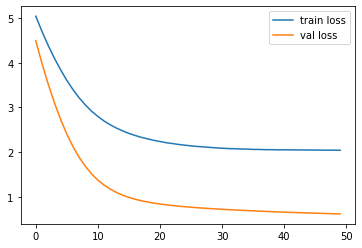

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_epoch_loss_lst, label='train loss')

plt.plot(train_epoch_loss, label='val loss')
plt.legend()

In [ ]:
scores = model(torch.tensor([20]).to(device), torch.tensor([20]).to(device))
scores

tensor([2.4434], device='cuda:0', grad_fn=<AddBackward0>)